# Détection de gravure par Deep Learning
### Premier modèle : 1 gravure par image

### Dataset

J'utilise le dataset que j'ai créé à cet effet.

Il est en local sur ma machine actuellement


In [1]:
!nvidia-smi

Mon Jun 30 11:12:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000                Off |   00000000:73:00.0  On |                  Off |
| 33%   34C    P8             22W /  230W |     362MiB /  16384MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Préparation des données

In [3]:
groundtruth_folder = 'gravures'
data_folder = 'murs_graves'

In [4]:
import os
from sklearn.model_selection import train_test_split

# Get the list of groundtruth and data files
groundtruth_files = sorted(os.listdir(groundtruth_folder))
data_files = sorted(os.listdir(data_folder))

# Create pairs: for each groundtruth "something.png", match all data files "something_i.png"
data_pairs = []
NB_data_files = 1
for gt_file in groundtruth_files:
  base_name = os.path.splitext(gt_file)[0]  # "something"
  # Find all data files that start with "something_" and end with ".png"
  matching_data_files = [f for f in data_files if f.startswith(f"{base_name}_") and f.endswith(".png")]
  NB_data_files = len(matching_data_files)
  # add pairs of ([all groundtruth_files], data_file)
  data_pairs.append((matching_data_files, gt_file))

# Split the data into training, validation, and test sets
# Let's use a split of 70% training, 15% validation, 15% testing
train_val_data, test_data = train_test_split(data_pairs, test_size=0.10, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=(0.08 / 0.90), random_state=42) # Adjust test_size for the remaining data

print(f"Total data pairs: {len(data_pairs)}")
print(f"Training data pairs: {len(train_data)}")
print(f"Validation data pairs: {len(val_data)}")
print(f"Test data pairs: {len(test_data)}")

Total data pairs: 1000
Training data pairs: 820
Validation data pairs: 80
Test data pairs: 100


In [5]:
# Old code to load images
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import numpy as np

# IMG_HEIGHT = 512
# IMG_WIDTH = 512
# IMG_CHANNELS = 1  # 1 for grayscale
# IMG_NB = NB_data_files

# def load_data(data_pairs):
#     images = []
#     masks = []
#     for img_path_tab, mask_path in data_pairs:
#         imgs = []
#         for img_path in img_path_tab:
#             img = load_img(os.path.join(data_folder, img_path), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
#             imgs.append(img_to_array(img) / 255.0)
#         imgs = np.stack(imgs, axis=0)  # shape: (NB_data_files, IMG_HEIGHT, IMG_WIDTH, 1)

#         mask = load_img(os.path.join(groundtruth_folder, mask_path), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
#         # shape: (IMG_HEIGHT, IMG_WIDTH, 1)
#         images.append(imgs)
#         masks.append(1 - img_to_array(mask) / 255.0)
#     return np.array(images), tf.cast(np.array(masks),tf.float32)

# x_train, y_train = load_data(train_data)
# x_val, y_val = load_data(val_data)
# x_test, y_test = load_data(test_data)

# print(tf.reduce_sum(y_train[1]))  # Check if the mask is not all ones (white pxls)
# print(y_train[1].shape[0]*y_train[1].shape[1])

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

class DataGenerator(Sequence):
    def __init__(self, data_pairs, batch_size, img_height, img_width, img_channels, nb_data_files, data_folder, groundtruth_folder, shuffle=True):
        self.data_pairs = data_pairs
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels
        self.nb_data_files = nb_data_files
        self.data_folder = data_folder
        self.groundtruth_folder = groundtruth_folder
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_pairs) / self.batch_size))

    def __getitem__(self, index):
        batch_pairs = self.data_pairs[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        masks = []
        for img_path_tab, mask_path in batch_pairs:
            imgs = []
            for img_path in img_path_tab:
                img = load_img(os.path.join(self.data_folder, img_path), target_size=(self.img_height, self.img_width), color_mode="grayscale")
                imgs.append(img_to_array(img) / 255.0)
            imgs = np.stack(imgs, axis=0)
            mask = load_img(os.path.join(self.groundtruth_folder, mask_path), target_size=(self.img_height, self.img_width), color_mode="grayscale")
            images.append(imgs)
            masks.append(1 - img_to_array(mask) / 255.0)
        X = tf.convert_to_tensor(np.array(images), dtype=tf.float32)
        y = tf.cast(np.array(masks), tf.float32)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.data_pairs)


2025-06-30 11:12:17.777942: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 11:12:17.780276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-30 11:12:17.824747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-30 11:12:17.825881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-30 11:12:18.600436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Modèle

In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1  # 1 for grayscale
IMG_NB = NB_data_files if 'NB_data_files' in locals() else 10

In [4]:
from tensorflow.keras.layers import Input, Conv2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose
from tensorflow.keras.layers import Lambda


def build_unet(input_shape):
    # For 3D input (batch, depth, height, width, channels), use Conv3D, MaxPooling3D, etc.
    inputs = Input(input_shape)

    # Downsampling
    c1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((1, 2, 2))(c1)  # Only pool spatially, not across the stack

    c2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((1, 2, 2))(c2)

    c_extra = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p2)
    c_extra = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c_extra)
    p_extra = MaxPooling3D((1, 2, 2))(c_extra)

    # Bottleneck
    b = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p_extra)
    b = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(b)

    # Upsampling
    u_extra = Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(b)
    u_extra = concatenate([u_extra, c_extra])
    c_up_extra = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u_extra)
    c_up_extra = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c_up_extra)

    u1 = Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(c_up_extra)
    u1 = concatenate([u1, c2])
    c3 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u1)
    c3 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c3)

    u2 = Conv3DTranspose(16, (1, 2, 2), strides=(1, 2, 2), padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(u2)
    c4 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c4)

    # Output shape: (batch, depth, height, width, 1)
    # outputs_3d = Conv3D(1, (input_shape[0], 1, 1), activation='sigmoid')(c4)

    # somme des couches sur la profondeur
    outputs_3d = Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True))(c4)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(outputs_3d)  # Remove the depth dimension
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(outputs)

    return Model(inputs, outputs)

model = build_unet((IMG_NB, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 512, 512, 1)]    0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 10, 512, 512, 16)     448       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 10, 512, 512, 16)     6928      ['conv3d[0][0]']              
                                                                                                  


2025-06-30 11:12:29.818027: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


 max_pooling3d (MaxPooling3  (None, 10, 256, 256, 16)     0         ['conv3d_1[0][0]']            
 D)                                                                                               
                                                                                                  
 conv3d_2 (Conv3D)           (None, 10, 256, 256, 32)     13856     ['max_pooling3d[0][0]']       
                                                                                                  
 conv3d_3 (Conv3D)           (None, 10, 256, 256, 32)     27680     ['conv3d_2[0][0]']            
                                                                                                  
 max_pooling3d_1 (MaxPoolin  (None, 10, 128, 128, 32)     0         ['conv3d_3[0][0]']            
 g3D)                                                                                             
                                                                                                  
 conv3d_4 

### Entraînement

In [5]:
# Losses
def dice_loss(y_true, y_pred, smooth=1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true*y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# Metrics
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath=f'checkpoints/best.weights.h5', save_weights_only=True, save_best_only=True, monitor='loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

In [ ]:
# Old code to compile and fit the model

# model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[f1_score_metric])

# history = model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=[checkpoint, early_stopping]
# )

# model.save('unet_model.h5')

In [18]:
train_gen = DataGenerator(train_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NB_data_files, data_folder, groundtruth_folder)
val_gen = DataGenerator(val_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NB_data_files, data_folder, groundtruth_folder, shuffle=False)
test_gen = DataGenerator(test_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NB_data_files, data_folder, groundtruth_folder, shuffle=False)

NameError: name 'train_data' is not defined

In [14]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[f1_score_metric])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

model.save('unet_model.h5')

# import gc
# globals().clear()

# # kill the kernel to free up memory
# import os
# os._exit(0)  # This will terminate the kernel and free up memory


Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 1.0899 - f1_score_metric: 0.0111 
Epoch 1: loss improved from inf to 1.08991, saving model to checkpoints/best.weights.h5
52/52 [==============================] - 1340s 26s/step - loss: 1.0899 - f1_score_metric: 0.0111 - val_loss: 1.0326 - val_f1_score_metric: 0.0182
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 1.0288 - f1_score_metric: 0.0249 
Epoch 2: loss improved from 1.08991 to 1.02885, saving model to checkpoints/best.weights.h5
52/52 [==============================] - 1308s 25s/step - loss: 1.0288 - f1_score_metric: 0.0249 - val_loss: 1.0138 - val_f1_score_metric: 0.0315
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.9408 - f1_score_metric: 0.1151 
Epoch 3: loss improved from 1.02885 to 0.94076, saving model to checkpoints/best.weights.h5
52/52 [==============================] - 1317s 25s/step - loss: 0.9408 - f1_score_metric: 0.1151 - val_loss: 0.8501 - val_f1_score

/home/nrr6650/dev/training/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import matplotlib.pyplot as plt
# # essaie d'overfit sur un seul exemple
# x_sample = x_train[0:1]  # shape (1, Z, H, W, C)
# y_sample = y_train[0:1]  # shape (1, H, W, 1)

# model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[])

# # Entraîner longtemps sur ce seul exemple
# history = model.fit(
#     x_sample, y_sample,
#     epochs=80,
#     verbose=1  # Mets 1 si tu veux voir le log à chaque epoch
# )

# # Prédiction
# y_pred = model.predict(x_sample)[0]  # shape (H, W, 1)

# print(y_pred.min(), y_pred.max(), y_pred.mean())
# seuil = y_pred.mean()
# #y_pred = (y_pred > seuil).astype(np.float32)  # Binarise la prédiction

# # Affichage
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(x_sample[0, x_sample.shape[1] // 2, ..., 0], cmap='gray')
# plt.title('Image (slice centrale)')
# plt.subplot(1, 3, 2)
# plt.imshow(y_sample[0, ..., 0], cmap='gray')
# plt.title('Mask réel')
# plt.subplot(1, 3, 3)
# plt.imshow(y_pred[..., 0], cmap='gray')
# plt.title('Prediction')
# plt.show()


### Prédictions

In [24]:
import matplotlib.pyplot as plt

# Récupération des données
acc = history.history['f1_score_metric']
val_acc = history.history['val_f1_score_metric']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Création des graphiques
plt.figure(figsize=(14, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train f1-score')
plt.plot(epochs_range, val_acc, label='Val f1-score')
plt.title('F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend(loc='lower right')

# Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

In [ ]:
# Old code to evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# # Prédiction sur quelques images
# preds = model.predict(x_test[:5])

# # Affichage exemple
# import matplotlib.pyplot as plt

# for i in range(5):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(x_test[i,1], cmap='gray')
#     plt.title("Image")

#     plt.subplot(1, 3, 2)
#     plt.imshow(y_test[i], cmap='gray')
#     plt.title("Ground Truth")

#     plt.subplot(1, 3, 3)
#     plt.imshow(preds[i], cmap='gray')
#     plt.title("Prediction")
#     plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle depuis le fichier .h5

model = load_model('unet_model.h5', custom_objects={'bce_dice_loss': bce_dice_loss, 'f1_score_metric': f1_score_metric})

# Évaluation avec le générateur
loss, f1 = model.evaluate(test_gen)
print(f"Test Loss: {loss}, Test F1-score: {f1}")

# Prédiction sur quelques images du générateur
X_batch, y_batch = test_gen[0]  # Prend le premier batch
preds = model.predict(X_batch)

import matplotlib.pyplot as plt

for i in range(min(5, X_batch.shape[0])):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_batch[i, X_batch.shape[1] // 2, ..., 0], cmap='gray')
    plt.title("Image (slice centrale)")

    plt.subplot(1, 3, 2)
    plt.imshow(y_batch[i, ..., 0], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i, ..., 0], cmap='gray')
    plt.title("Prediction")
    plt.show()


In [ ]:
preds = model.predict(x_test[5:10])

for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[5 + i, 1], cmap='gray')
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[5 + i], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i], cmap='gray')
    plt.title("Prediction")
    plt.show()


### Fine Tuning avec des données annotées

In [6]:
MODEL_NAME = 'unet_model_finetuned_20ep.h5'

NEW_GROUNDTRUTH_FOLDER = 'dataset_omoplate/omoplate_calques_rot'
NEW_DATA_FOLDER = 'dataset_omoplate/omoplate'

BATCH_SIZE = 8

In [8]:
from tensorflow.keras.models import load_model
import os

# Charger le modèle existant
model = load_model(MODEL_NAME, custom_objects={'bce_dice_loss': bce_dice_loss, 'f1_score_metric': f1_score_metric})

# Générer les paires (similaire à la cellule 5)
new_groundtruth_files = sorted(os.listdir(NEW_GROUNDTRUTH_FOLDER))
new_data_files = sorted(os.listdir(NEW_DATA_FOLDER))

new_data_pairs = []
for gt_file in new_groundtruth_files:
    base_name = os.path.splitext(gt_file)[0]
    matching_data_files = [f for f in new_data_files if f.startswith(f"{base_name}_") and f.endswith(".png")]
    new_data_pairs.append((matching_data_files, gt_file))

# Créer un DataGenerator pour le fine-tuning
new_gen = DataGenerator(new_data_pairs, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, IMG_NB, NEW_DATA_FOLDER, NEW_GROUNDTRUTH_FOLDER)

# Fine-tuning du modèle
model.fit(
    new_gen,
    epochs=50,  # Ajuste le nombre d'epochs selon tes besoins
    callbacks=[checkpoint, early_stopping]
)

# Sauvegarder le modèle fine-tuné
model.save('unet_model_finetuned.h5')

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.0559 - f1_score_metric: 0.2454 
Epoch 1: loss improved from inf to 1.05593, saving model to checkpoints/best.weights.h5
11/11 [==============================] - 156s 14s/step - loss: 1.0559 - f1_score_metric: 0.2454
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.0526 - f1_score_metric: 0.2515 
Epoch 2: loss improved from 1.05593 to 1.05262, saving model to checkpoints/best.weights.h5
11/11 [==============================] - 151s 14s/step - loss: 1.0526 - f1_score_metric: 0.2515
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.0390 - f1_score_metric: 0.2583 
Epoch 3: loss improved from 1.05262 to 1.03895, saving model to checkpoints/best.weights.h5
11/11 [==============================] - 150s 14s/step - loss: 1.0390 - f1_score_metric: 0.2583
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 1.0192 - f1_score_metric: 0.2808 
Epoch 4: loss improved from 1.03

/home/nrr6650/dev/training/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Utilisation sur des données réels

In [9]:
# l'image est redimensionnée à Height x Width
IMG_PATH = './omoplate.png'

1/1 [==============================] - 1s 877ms/step


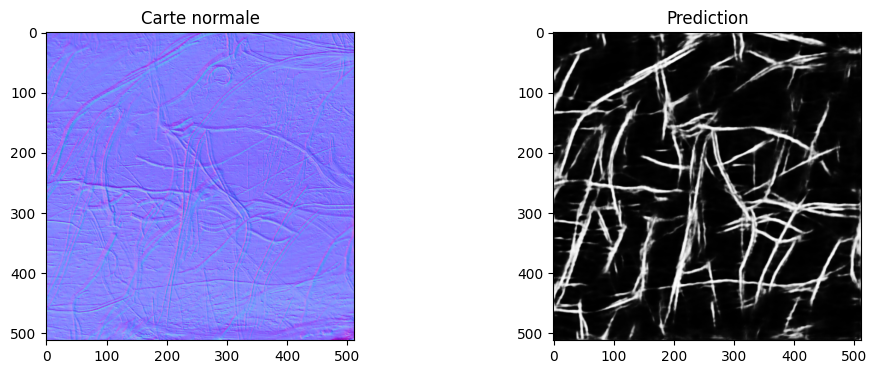

In [11]:
import integrate_normals as inorm
import matplotlib.pyplot as plt
inorm.process_image_stereo(IMG_PATH, './img_a_pred/image.png', nb_images=10, z_height=0.7)

data_f = sorted(os.listdir('./img_a_pred/'))

im_stack = []
for img_path in data_f:
    img = load_img(os.path.join('./img_a_pred/', img_path), target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    im_stack.append(img_to_array(img) / 255.0)
im_stack = np.stack(im_stack, axis=0) # shape: (NB_data_files, IMG_HEIGHT, IMG_WIDTH, 1)

pred = model.predict(np.expand_dims(im_stack, axis=0))[0]

carte_normale = load_img(IMG_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="rgb")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(carte_normale)
plt.title("Carte normale")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Prediction")
plt.show()